In [869]:
import time

import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
from jax.example_libraries import optimizers

from jax.config import config
config.update("jax_enable_x64", True)


import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('seaborn-white')
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

print("DEBUG Jax device:",jax.devices())

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from jax.example_libraries import stax
from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

DEBUG Jax device: [<jaxlib.xla_extension.Device object at 0x7f5c986d4030>]


# Simple classification en 2D

In [896]:
num_features = 2
num_classes  = 5
batch_size   = 5
# Generate key which is used to generate random numbers
key = random.PRNGKey(42)

## Models:
- Simple model linéaire 
- Un Neural net à 1 couche cachée et un rectificateur comme non-linéairité

In [899]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [900]:
n_samples = 1500
np.random.seed(0)
X, y= datasets.make_blobs(n_samples=2*n_samples, random_state=20,centers=num_classes)
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [901]:
y

array([2, 2, 0, ..., 0, 2, 0])

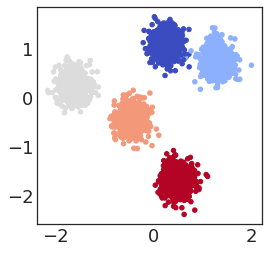

In [902]:
plt.scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
plt.gca().set_aspect('equal')

In [903]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [904]:
X_train.shape,  y_train.shape,X_test.shape, y_test.shape

((2010, 2), (2010,), (990, 2), (990,))

In [905]:
from torch.utils.data import Dataset,  DataLoader


In [906]:
jnp.array([0])

DeviceArray([0], dtype=int64)

In [907]:
class MyDataset(Dataset):

    def __init__(self, X,y):
        self.x_data, self.y_data = X,y
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

    def __len__(self):
        return len(self.x_data)


In [908]:
dataset_train = MyDataset(X_train,y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = MyDataset(X_test,y_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [913]:
def plot_performance(train_loss, train_acc, test_acc,
                           sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier on MNIST """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_loss)
    axs[0].set_xlabel("# Batch Updates")
    axs[0].set_ylabel("Batch Loss")
    axs[0].set_title("Training Loss")

    axs[1].plot(train_acc, lw=3, label="Training")
    axs[1].plot(test_acc, lw=3, ls="--", label="Test")
    axs[1].set_xlabel("# Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Prediction Accuracy")
    axs[1].legend()

    # Give data more room to bloom!
    for i in range(2):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)

    fig.suptitle(sup_title, fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.925])

In [938]:
import functools

In [943]:
class Classif():
    def __init__(self, clf):
        
        step_size = 1e-3
        self.num_features = 2
        self.num_classes  = 5
        self.batch_size   = 5

        self.init_nn, self.apply_nn = clf
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(step_size)

    def loss(self, params, data, targets):
        preds = self.apply_nn(params, data)
        return -jnp.sum(preds * targets)

    @functools.partial(jit, static_argnums=0)
    def update(self, params, x, y, opt_state):
        """ Compute the gradient for a batch and update the parameters """
        value, grads = value_and_grad(self.loss)(params, x, y)
        opt_state = self.opt_update(0, grads, opt_state)
        return self.get_params(opt_state), opt_state, value
    
    def accuracy(self, params, data_loader):
        acc_total = 0
        for batch_idx, (data, target) in enumerate(data_loader):
            data = jnp.array(data)
            targets = one_hot(np.array(target), self.num_classes)

            target_class = jnp.argmax(targets, axis=1)
            predicted_class = jnp.argmax(self.apply_nn(params, data), axis=1)
            acc_total += jnp.sum(predicted_class == target_class)
        return acc_total/len(data_loader.dataset)



    def run_training_loop(self, num_epochs, train_loader, test_loader, seed=42):
        """ Implements a learning loop over epochs. """
        # Initialize placeholder for loggin
        log_acc_train, log_acc_test, train_loss = [], [], []
        
        key = jax.random.PRNGKey(seed)
        _,params_init = self.init_nn(key, (self.batch_size, self.num_features))
        opt_state = self.opt_init(params_init)

        # Get the initial set of parameters
        params = self.get_params(opt_state)
    
        # Get initial accuracy after random init
        train_acc = self.accuracy(params, train_loader)
        test_acc = self.accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
    
        print(f"begin: train_acc {train_acc:0.4f}, test_acc {test_acc:0.4f} ")

        # Loop over the training epochs
        for epoch in range(num_epochs):
            start_time = time.time()
            for batch_idx, (data, target) in enumerate(train_loader):
                x = jnp.array(data)
                y = one_hot(np.array(target), self.num_classes)
                params, opt_state, loss = self.update(params, x, y, opt_state)
                train_loss.append(loss)

            epoch_time = time.time() - start_time
            train_acc = self.accuracy(params, train_loader)
            test_acc = self.accuracy(params, test_loader)
            log_acc_train.append(train_acc)
            log_acc_test.append(test_acc)
            print(f"Epoch {epoch+1} | T: {epoch_time:0.2f} | Train Acc: {train_acc:0.4f} | Test Acc: {test_acc:0.4f}")

        return train_loss, log_acc_train, log_acc_test, params, params_init



In [952]:

model = stax.serial(Dense(num_classes),
                        LogSoftmax
                      )
clf = Classif(model)

num_epochs=40
train_loss, log_acc_train, log_acc_test, params, params_init = \
        clf.run_training_loop(num_epochs, train_loader, test_loader)

init_nn, apply_nn = model

begin: train_acc 0.2279, test_acc 0.2131 
Epoch 1 | T: 0.79 | Train Acc: 0.5896 | Test Acc: 0.5768
Epoch 2 | T: 0.30 | Train Acc: 0.6264 | Test Acc: 0.6192
Epoch 3 | T: 0.30 | Train Acc: 0.7035 | Test Acc: 0.7111
Epoch 4 | T: 0.30 | Train Acc: 0.7945 | Test Acc: 0.7919
Epoch 5 | T: 0.39 | Train Acc: 0.8617 | Test Acc: 0.8535
Epoch 6 | T: 0.34 | Train Acc: 0.9095 | Test Acc: 0.8960
Epoch 7 | T: 0.37 | Train Acc: 0.9443 | Test Acc: 0.9333
Epoch 8 | T: 0.31 | Train Acc: 0.9662 | Test Acc: 0.9576
Epoch 9 | T: 0.45 | Train Acc: 0.9776 | Test Acc: 0.9667
Epoch 10 | T: 0.36 | Train Acc: 0.9836 | Test Acc: 0.9747
Epoch 11 | T: 0.38 | Train Acc: 0.9891 | Test Acc: 0.9848
Epoch 12 | T: 0.30 | Train Acc: 0.9910 | Test Acc: 0.9899
Epoch 13 | T: 0.34 | Train Acc: 0.9930 | Test Acc: 0.9929
Epoch 14 | T: 0.34 | Train Acc: 0.9950 | Test Acc: 0.9929
Epoch 15 | T: 0.38 | Train Acc: 0.9955 | Test Acc: 0.9929
Epoch 16 | T: 0.32 | Train Acc: 0.9965 | Test Acc: 0.9939
Epoch 17 | T: 0.39 | Train Acc: 0.9975 

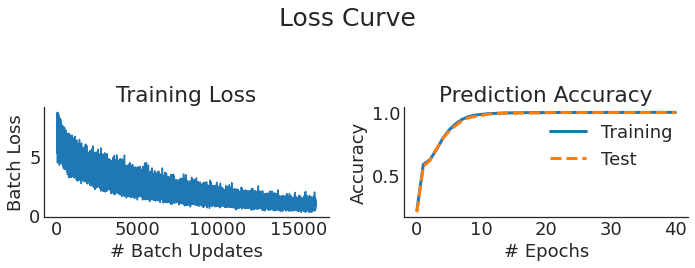

In [953]:
plot_performance(train_loss, log_acc_train, log_acc_test)

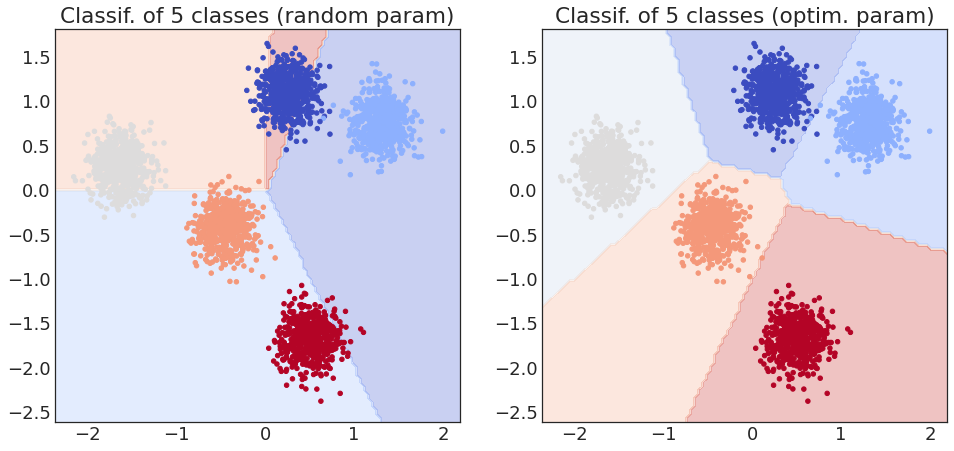

In [954]:
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])*1.1,np.max(X[:,0])*1.1,100), 
                     np.linspace(np.min(X[:,1])*1.1,np.max(X[:,1])*1.1,100))
positions = jnp.vstack([xx.ravel(), yy.ravel()]).T
predict_init = jnp.argmax(jnp.exp(apply_nn(params_init,positions)),axis=1)
f_init = np.reshape(predict_init,xx.shape)

predict = jnp.argmax(jnp.exp(apply_nn(params,positions)),axis=1)
f = np.reshape(predict,xx.shape)

fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].contourf(xx,yy,f_init,cmap=plt.cm.coolwarm, alpha=0.3)
axs[0].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[0].set_aspect('equal')
axs[0].set_title(f"Classif. of {num_classes} classes (random param)")

axs[1].contourf(xx,yy,f,cmap=plt.cm.coolwarm, alpha=0.3)
axs[1].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[1].set_aspect('equal')
axs[1].set_title(f"Classif. of {num_classes} classes (optim. param)");

In [956]:
n_hidden = 100
model= stax.serial(
        Dense(n_hidden),
        Relu,
        Dense(num_classes),
        LogSoftmax
)

In [957]:
clf1 = Classif(model)

num_epochs=40
train_loss, log_acc_train, log_acc_test, params, params_init = \
        clf1.run_training_loop(num_epochs, train_loader, test_loader)

init_nn, apply_nn = model

begin: train_acc 0.2040, test_acc 0.1909 
Epoch 1 | T: 1.14 | Train Acc: 0.9955 | Test Acc: 0.9960
Epoch 2 | T: 0.38 | Train Acc: 0.9990 | Test Acc: 0.9970
Epoch 3 | T: 0.31 | Train Acc: 0.9985 | Test Acc: 0.9970
Epoch 4 | T: 0.46 | Train Acc: 0.9985 | Test Acc: 0.9970
Epoch 5 | T: 0.41 | Train Acc: 0.9995 | Test Acc: 0.9970
Epoch 6 | T: 0.43 | Train Acc: 0.9995 | Test Acc: 0.9970
Epoch 7 | T: 0.35 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 8 | T: 0.40 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 9 | T: 0.40 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 10 | T: 0.31 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 11 | T: 0.31 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 12 | T: 0.30 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 13 | T: 0.34 | Train Acc: 0.9995 | Test Acc: 0.9980
Epoch 14 | T: 0.37 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 15 | T: 0.42 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 16 | T: 0.40 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 17 | T: 0.31 | Train Acc: 0.9995 

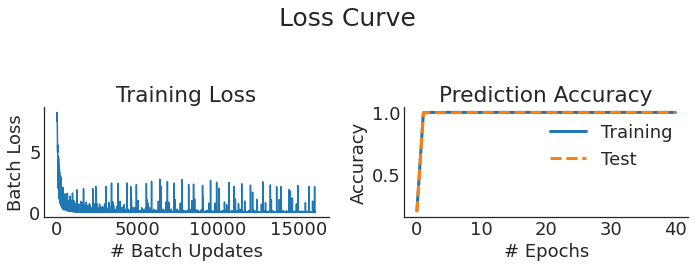

In [958]:
plot_performance(train_loss, log_acc_train, log_acc_test)

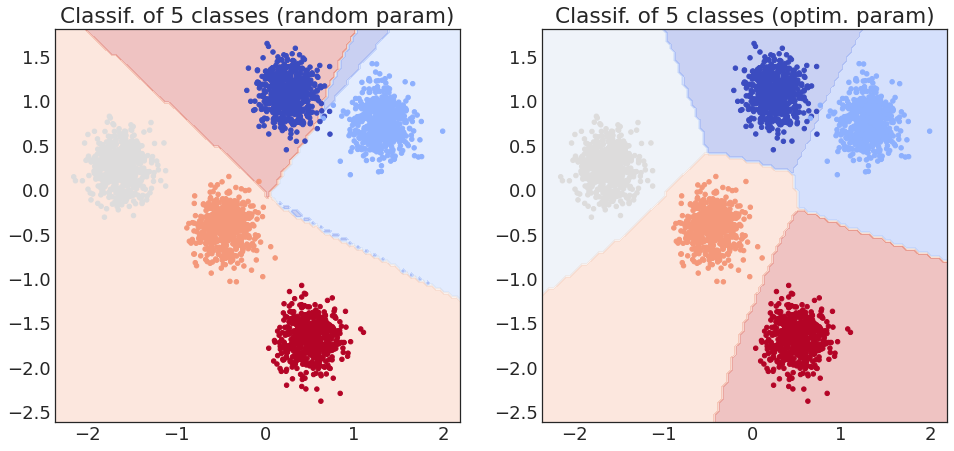

In [959]:
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])*1.1,np.max(X[:,0])*1.1,100), 
                     np.linspace(np.min(X[:,1])*1.1,np.max(X[:,1])*1.1,100))
positions = jnp.vstack([xx.ravel(), yy.ravel()]).T
predict_init = jnp.argmax(jnp.exp(apply_nn(params_init,positions)),axis=1)
f_init = np.reshape(predict_init,xx.shape)

predict = jnp.argmax(jnp.exp(apply_nn(params,positions)),axis=1)
f = np.reshape(predict,xx.shape)

fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].contourf(xx,yy,f_init,cmap=plt.cm.coolwarm, alpha=0.3)
axs[0].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[0].set_aspect('equal')
axs[0].set_title(f"Classif. of {num_classes} classes (random param)")

axs[1].contourf(xx,yy,f,cmap=plt.cm.coolwarm, alpha=0.3)
axs[1].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[1].set_aspect('equal')
axs[1].set_title(f"Classif. of {num_classes} classes (optim. param)");